In [48]:
using Lux
using Zygote
using Optimization
using OptimizationOptimisers
using Random
using Statistics
using DifferentialEquations
using Plots
using ComponentArrays

### True ODE Model and Synthetic Data Generation

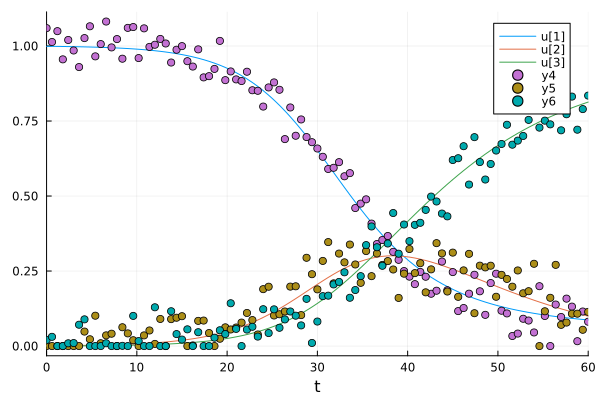

In [217]:
struct SIR_params
    β::Float32
    γ::Float32
end

# SIR model method for DifferentialEquations call 
function SIR_model!(du, u, p::SIR_params, t)
    S, I, R = u
    du[1] = -p.β * S * I 
    du[2] =  p.β * S * I - p.γ * I
    du[3] =  p.γ * I
end

# SIR model non mutating function method to calculate NN RHS
SIR_model(y::AbstractMatrix{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1, :] .* y[2, :]        
    dI = p.β .* y[1,:] .* y[2, :] - p.γ .* y[2, :]
    dR = p.γ .* y[2, :]                         
    permutedims(hcat(dS, dI, dR))
end

# Fast default RNG. Does not get messed up with a global RNG
rng = Random.MersenneTwister(42)

true_SIR_par = SIR_params(0.30, 0.1)
t_span = (0.0, 60.0)
N_obs = 101

# Collect seems to turn an iterable into an array
t_obs_array = range(t_span[1], t_span[2], length=N_obs) |> collect
u0 = [0.999, 0.001, 0.0]

prob = DifferentialEquations.ODEProblem(SIR_model!, u0, t_span, true_SIR_par)
sol = DifferentialEquations.solve(
    prob,
    DifferentialEquations.Tsit5();
    saveat = t_obs_array
)
sol_ = Array(sol)

# Add some noise
noise_sd = 0.05
noisy_data = clamp.(begin
    sol_ + noise_sd.* Random.randn(rng, size(sol_)...) 
end,0, Inf)

# Convert to Float32 to keep everyone happy
t_train = Float32.(t_obs_array)
Y_train = Float32.(noisy_data)
y0_obs  = Y_train[:, 1]     # IC for penalty

Plots.plot(sol)
Plots.scatter!(t_train, Y_train[1,:])
Plots.scatter!(t_train, Y_train[2,:])
Plots.scatter!(t_train, Y_train[3,:])


### Setting up the NN

In [100]:
NN_model = Lux.Chain(
    Lux.Dense(1, 10, tanh),
    Lux.Dense(10, 10, tanh),
    Lux.Dense(10, 3)
)

ps, st = Lux.setup(rng, NN_model)
ps = ComponentArrays.ComponentArray(ps)

function predict_NN(model, ps, st, t_vec::AbstractVector{<:Real})
    t_in = reshape(Float32.(t_vec), 1, :)
    ŷ_n , _ = Lux.apply(model, t_in, ps, st)
    return ŷ_n
end


predict_NN (generic function with 1 method)

### Computing Loss

In [ ]:
function MSE(ŷ, y)
    Statistics.mean(abs2, vec(ŷ .- y))
end

λ_ic = 1.0f0*3
λ_ode = 1.0f0

# d/dt of NN output at a single time (returns 3-vector)
function dudt_nn(model, ps, st, t::Float32)
    # one scalar-target closure per output component
    f(i) = τ -> begin
        x = Float32[τ]   # 1×1 Matrix (array, not tuple)
        y, _ = Lux.apply(model, x, ps, st)   # destructure the tuple
        return y[i, 1]                       # scalar
    end
    dS = Zygote.gradient(f(1), t)[1]
    dI = Zygote.gradient(f(2), t)[1]
    dR = Zygote.gradient(f(3), t)[1]
    return Float32[dS, dI, dR]
end


function ODE_residual(model, ps, st, t_col::AbstractVector{<:Real}, p::SIR_params)
    acc = 0.0f0
    count = 0
    for tt in t_col
        t = Float32(tt)
        y = predict_NN(model, ps, st, Float32[t])[:,1]
        rhs = SIR_model(y,p)
        dydt = dudt_nn(model, ps, st, t)
        r = dydt .- rhs
        acc += sum(abs2, r); count += length(r)
    end
    return acc/count
end

function loss_supervised(ps, ctx)
    #ctx is a named tuple holding everything non-trainable
    model = ctx.model
    st = ctx.st
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    y0_obs = ctx.y0_obs
    λ_ic = ctx.λ_ic
    λ_ode = ctx.λ_ode

    ŷ = predict_NN(model, ps, st, t_train)
    data_mse = MSE(ŷ, Y_train)
    ic_mse = Statistics.mean(abs2, ŷ[:,1] .- y0_obs)
    ode_mse = ODE_residual(model, ps, st, t_train, true_SIR_par)
    return data_mse + ic_mse *λ_ic + λ_ode*ode_mse  
end

ctx = (
    model = NN_model,
    st = st,
    t_train = t_train,
    Y_train = Y_train,
    y0_obs = y0_obs,
    λ_ic = λ_ic,
    λ_ode = λ_ode

)

(model = Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 10, tanh), layer_2 = Dense(10 => 10, tanh), layer_3 = Dense(10 => 3)), nothing), st = (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple()), t_train = Float32[0.0, 0.6, 1.2, 1.8, 2.4, 3.0, 3.6, 4.2, 4.8, 5.4  …  54.6, 55.2, 55.8, 56.4, 57.0, 57.6, 58.2, 58.8, 59.4, 60.0], Y_train = Float32[1.059514 1.0133065 … 0.115106866 0.081107125; 0.0 0.0 … 0.054239936 0.11388435; 0.020175591 0.03076273 … 0.7896826 0.8346873], y0_obs = Float32[1.059514, 0.0, 0.020175591], λ_ic = 3.0f0, λ_ode = 1.0f0)

### Sanity Checks

In [238]:
temp(model, ps, st, t::AbstractVector{<:Real}, pars::SIR_params) = begin
    ŷ_NN = predict_NN(model, ps, st, t)
    f_ŷ_NN = SIR_model(ŷ_NN, pars)

    err_sum = sum(y -> begin
        tn = t_train[y];
        dNNdt_tn = Zygote.jacobian(x -> predict_NN(NN_model, ps, st, x), [tn])[1];
        err_t = mean(abs2, dNNdt_tn .-  f_ŷ_NN[:, y])
    end, eachindex(t))
    return err_sum
    #= for y in eachindex(t)
        tn = t_train[y]
        dNNdt_tn = Zygote.jacobian(x -> predict_NN(NN_model, ps, st, x), [y])[1]
        err_t = mean(abs2, dNNdt_tn .-  f_ŷ_NN[:, y])
    end =#
end

temp (generic function with 1 method)

In [239]:
temp(NN_model, ps, st, t_train, true_SIR_par)

8.607441f0

In [270]:
#= Zygote.gradient(y -> temp(NN_model, y, st, t_train, true_SIR_par), ps) =#

smodel = Lux.StatefulLuxLayer(NN_model, ps, st)
smodel(t_train')


Zygote.jacobian(smodel, t_train')[1]

303×101 Matrix{Float32}:
  2.51531    0.0       0.0        …  0.0         0.0         0.0
  0.441261   0.0       0.0           0.0         0.0         0.0
 -2.32792    0.0       0.0           0.0         0.0         0.0
  0.0        1.85356   0.0           0.0         0.0         0.0
  0.0        0.49248   0.0           0.0         0.0         0.0
  0.0       -1.1422    0.0        …  0.0         0.0         0.0
  0.0        0.0       0.300208      0.0         0.0         0.0
  0.0        0.0       0.0066507     0.0         0.0         0.0
  0.0        0.0      -0.245491      0.0         0.0         0.0
  0.0        0.0       0.0           0.0         0.0         0.0
  0.0        0.0       0.0        …  0.0         0.0         0.0
  0.0        0.0       0.0           0.0         0.0         0.0
  0.0        0.0       0.0           0.0         0.0         0.0
  ⋮                               ⋱                          ⋮
  0.0        0.0       0.0           0.0         0.0         0.0
  

In [273]:

Zygote.jacobian(y -> begin
    smodel = Lux.StatefulLuxLayer(NN_model, y, st)
    ŷ_NN = smodel([tn])
    f_ŷ_NN = SIR_model(ŷ_NN, true_SIR_par)
    dNNdt_tn = Zygote.jacobian(smodel, [tn])[1]
    Statistics.mean(abs2, f_ŷ_NN .- dNNdt_tn)
end, ps)[1]

1×163 Matrix{Float32}:
 0.204219  0.292301  -0.00130731  -0.00942678  …  0.0380118  0.183071  0.0

In [250]:
tn = 1f0;
ŷ_NN = predict_NN(NN_model, ps, st, [tn]);
f_ŷ_NN = SIR_model(ŷ_NN, true_SIR_par)
dNNdt_tn = Zygote.jacobian(x -> predict_NN(NN_model, ps, st, x), [tn])[1]

3×1 Matrix{Float32}:
  0.6094484
  0.041981753
 -0.36340204

0.21289809f0

In [190]:
#t = hcat([Zygote.jacobian(x -> predict_NN(NN_model, ps, st, x), [y])[1] for y in t_train])

f = y -> Zygote.jacobian(x -> predict_NN(NN_model, ps, st, x), [y])[1]

f.(0.5f0)


3×1 Matrix{Float32}:
  2.1200392
  0.5680177
 -1.3775536

In [188]:
[Zygote.jacobian(x -> predict_NN(NN_model, ps, st, x)[y], t_train)[1] for y in 1:3]

3-element Vector{Matrix{Float32}}:
 [2.515306 0.0 … 0.0 0.0]
 [0.44126102 0.0 … 0.0 0.0]
 [-2.3279204 0.0 … 0.0 0.0]

### Optimization

In [113]:
#=
optfun = Optimization.OptimizationFunction(
    (x, p) -> loss_supervised(x,p),
    Optimization.AutoZygote()
)
prob_fit = Optimization.OptimizationProblem(optfun, ps, ctx)
res = Optimization.solve(prob_fit, OptimizationOptimisers.Adam(1e-03); maxiters=5_000)
ps_trained = res.u =#

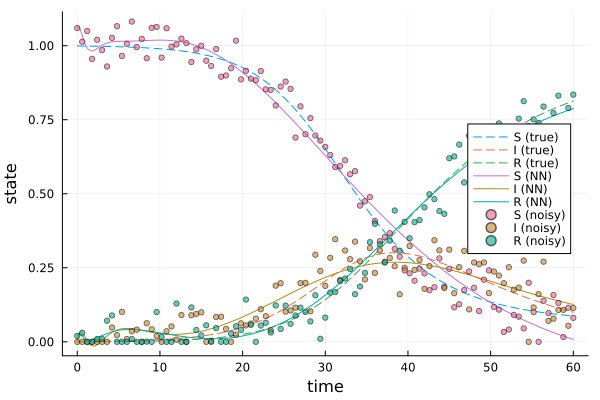

In [85]:
# --- Smooth curves on a dense grid ---
t_plot = collect(range(first(t_train), last(t_train), length=1000))

# True SIR (interpolated from the ODE solution)
Y_true_plot = Float32.(hcat([sol(t) for t in t_plot]...))   # (3, length(t_plot))

# NN prediction on the same dense grid
Yhat_plot = predict_NN(NN_model, ps_trained, st, Float32.(t_plot))  # (3, length(t_plot))

# --- Single figure with all three states ---
plt = Plots.plot(; xlabel = "time", ylabel = "state", legend = :right)

# True (dashed)
Plots.plot!(plt, t_plot, vec(Y_true_plot[1, :]); linestyle = :dash, label = "S (true)")
Plots.plot!(plt, t_plot, vec(Y_true_plot[2, :]); linestyle = :dash, label = "I (true)")
Plots.plot!(plt, t_plot, vec(Y_true_plot[3, :]); linestyle = :dash, label = "R (true)")

# NN (solid)
Plots.plot!(plt, t_plot, vec(Yhat_plot[1, :]); linestyle = :solid, label = "S (NN)")
Plots.plot!(plt, t_plot, vec(Yhat_plot[2, :]); linestyle = :solid, label = "I (NN)")
Plots.plot!(plt, t_plot, vec(Yhat_plot[3, :]); linestyle = :solid, label = "R (NN)")

# Noisy scatter
Plots.scatter!(plt, t_train, Y_train[1, :]; ms = 3, alpha = 0.6, label = "S (noisy)")
Plots.scatter!(plt, t_train, Y_train[2, :]; ms = 3, alpha = 0.6, label = "I (noisy)")
Plots.scatter!(plt, t_train, Y_train[3, :]; ms = 3, alpha = 0.6, label = "R (noisy)")

Plots.display(plt)
